In [ ]:
!pip install pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 37.9 MB/s eta 0:00:00


In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.1 --progress-bar off
!pip install -qqq accelerate==0.23.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off
!pip install -qqq llava-torch==1.1.1 --progress-bar off


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.
torchaudio 2.1.0+cu121 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.


In [ ]:
import io
import textwrap
import requests
import torch
from PIL import Image
from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (
    KeywordsStoppingCriteria,
    get_model_name_from_path,
    process_images,
    tokenizer_image_token,
)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
import fitz  # PyMuPDF

disable_torch_init()

def pdf_to_images(pdf_path, output_path):
    doc = fitz.open(pdf_path)

    for page_num in range(doc.page_count):
        page = doc[page_num]
        image_list = page.get_images(full=True)

        for img_index, img in enumerate(image_list):
            image_index = img[0]
            base_image = doc.extract_image(image_index)
            image_bytes = base_image["image"]
            image = Image.open(io.BytesIO(image_bytes))
            image.save(f"{output_path}/page{page_num + 1}_img{img_index + 1}.png", "PNG")

    doc.close()



MODEL = "4bit/llava-v1.5-13b-3GB"
model_name = get_model_name_from_path(MODEL)
model_name

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=MODEL, model_base=None, model_name=model_name, load_4bit=True
)


[2024-01-29 04:37:07,216] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def pdf_to_images(pdf_path, output_path):
    doc = fitz.open(pdf_path)

    for page_num in range(doc.page_count):
        page = doc[page_num]
        image_list = page.get_images(full=True)

        for img_index, img in enumerate(image_list):
            image_index = img[0]
            base_image = doc.extract_image(image_index)
            image_bytes = base_image["image"]
            image = Image.open(io.BytesIO(image_bytes))
            image.save(f"{output_path}/page{page_num + 1}_img{img_index + 1}.png", "PNG")

    doc.close()
pdf_path = "/content/drive/MyDrive/Data Science Interview Preparation Questions(#Day06).pdf"
output_path = "/content/drive/MyDrive/output"
pdf_to_images(pdf_path, output_path)

In [ ]:
def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(io.BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image

def process_image(image):
    args = {"image_aspect_ratio": "pad"}
    image_tensor = process_images([image], image_processor, args)
    return image_tensor.to(model.device, dtype=torch.float16)

CONV_MODE = "llava_v0"

def create_prompt(prompt: str):
    conv = conv_templates[CONV_MODE].copy()
    roles = conv.roles
    prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    conv.append_message(roles[0], prompt)
    conv.append_message(roles[1], None)
    return conv.get_prompt(), conv

def ask_image(image: Image, prompt: str):
    image_tensor = process_image(image)
    prompt, conv = create_prompt(prompt)
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )
    return tokenizer.decode(
        output_ids[0, input_ids.shape[1] :], skip_special_tokens=True
    ).strip()

# Process each image created from the PDF
for page_num in range(1, 1 + fitz.open(pdf_path).page_count):
    image_path = f"{output_path}/page{page_num}_img1.png"
    image = load_image(image_path)
    image.resize((600, 800))

    # Provide a prompt for each image
    prompt = f"Describe the content of page {page_num}."

    result = ask_image(image, prompt)
    print(f"Description for page {page_num}:\n{textwrap.fill(result, width=110)}")

Description for page 1:
Page 1 features a blue background with a white logo in the center. The logo is a combination of the letters
"UR" and a small sun symbol. The design is minimalistic and modern, with the focus on the logo and the blue
background.
Description for page 2:
Page 2 of the image features a blue and white logo, which is likely the name of a company or brand. The logo
is displayed prominently in the center of the page, with a white background. The design of the logo is simple
and clean, making it easily recognizable and memorable.
Description for page 3:
Page 3 of the image features a blue and white logo, which is likely the name of a company or brand. The logo
is displayed prominently in the center of the page, with a white background. The design of the logo is simple
and clean, making it easily recognizable and memorable.
Description for page 4:
Page 4 of the book is titled "The Universe." It features a blue background with white text, which reads "The
Universe." The pa

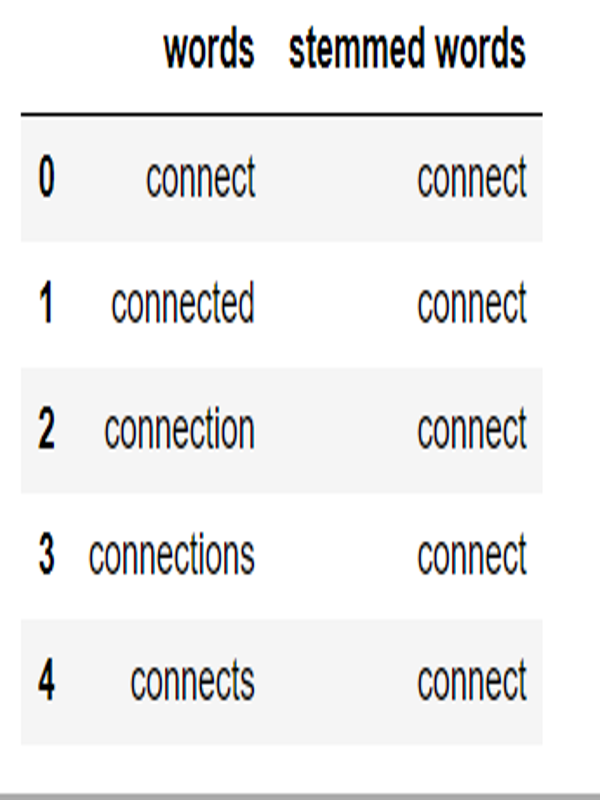

In [ ]:


image = load_image("/content/drive/MyDrive/output/page3_img2.png")
image.resize((600, 800))

In [ ]:

%%time
result = ask_image(image, "What is the title of the paper?")
print(textwrap.fill(result, width=110))


The title of the paper is "Words, Stemmed Words, and Connections."
CPU times: user 3.44 s, sys: 137 ms, total: 3.58 s
Wall time: 5.3 s


# Multiple pdf

In [ ]:
def pdf_to_images(pdf_path, output_path):
    doc = fitz.open(pdf_path)

    for page_num in range(doc.page_count):
        page = doc[page_num]
        image_list = page.get_images(full=True)

        for img_index, img in enumerate(image_list):
            base_image = doc.extract_image(img[0])
            image_bytes = base_image["image"]
            image = Image.open(io.BytesIO(image_bytes))
            image.save(f"{output_path}/page{page_num + 1}_img{img_index + 1}.png", "PNG")

    doc.close()

def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(io.BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image

def process_image(image, image_processor, model):
    args = {"image_aspect_ratio": "pad"}
    image_tensor = process_images([image], image_processor, args)
    return image_tensor.to(model.device, dtype=torch.float16)

def create_prompt(prompt: str, conv_templates, DEFAULT_IMAGE_TOKEN, SeparatorStyle):
    conv = conv_templates["llava_v0"].copy()
    roles = conv.roles
    prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    conv.append_message(roles[0], prompt)
    conv.append_message(roles[1], None)
    return conv.get_prompt(), conv

def ask_image(image: Image, prompt: str, tokenizer, model, conv_templates, DEFAULT_IMAGE_TOKEN, SeparatorStyle):
    image_tensor = process_image(image, image_processor, model)
    prompt, conv = create_prompt(prompt, conv_templates, DEFAULT_IMAGE_TOKEN, SeparatorStyle)
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )
    return tokenizer.decode(
        output_ids[0, input_ids.shape[1] :], skip_special_tokens=True
    ).strip()
output_path = "/content/drive/MyDrive/output2"

# List of PDF files to process
pdf_files = ["/content/drive/MyDrive/Data Science Interview Preparation Questions(#Day06).pdf", "/content/drive/MyDrive/Official High School Transcript.pdf", "/content/drive/MyDrive/abhi199.pdf", "/content/drive/MyDrive/abhishek_cv2.pdf", "/content/drive/MyDrive/cover_letter.pdf"]

# Process each PDF file
for pdf_path in pdf_files:
    pdf_to_images(pdf_path, output_path)

    # Process each image created from the PDF
    for page_num in range(1, 1 + fitz.open(pdf_path).page_count):
        image_path = f"{output_path}/page{page_num}_img1.png"
        image = load_image(image_path)
        image.resize((600, 800))

        # Provide a prompt for each image
        prompt = f"Describe the content of page {page_num} from {pdf_path}."

        result = ask_image(image, prompt, tokenizer, model, conv_templates, DEFAULT_IMAGE_TOKEN, SeparatorStyle)
        print(f"Description for page {page_num} of {pdf_path}:\n{textwrap.fill(result, width=110)}")

Description for page 1 of /content/drive/MyDrive/Data Science Interview Preparation Questions(#Day06).pdf:
Page 1 from the document "Data Science Interview Preparation Questions (#Day06).pdf" contains a list of
questions related to data science. The questions are organized in a table format, with each question
accompanied by a brief description. The table is divided into two sections, with the first section focusing on
questions related to statistics and probability, and the second section covering questions on machine learning
and data analysis. The questions are designed to help individuals prepare for data science interviews by
providing a comprehensive understanding of the concepts and techniques commonly tested in such interviews.
Description for page 2 of /content/drive/MyDrive/Data Science Interview Preparation Questions(#Day06).pdf:
Page 2 from the document "Data Science Interview Preparation Questions (#Day06).pdf" contains a list of
questions related to data science and machi

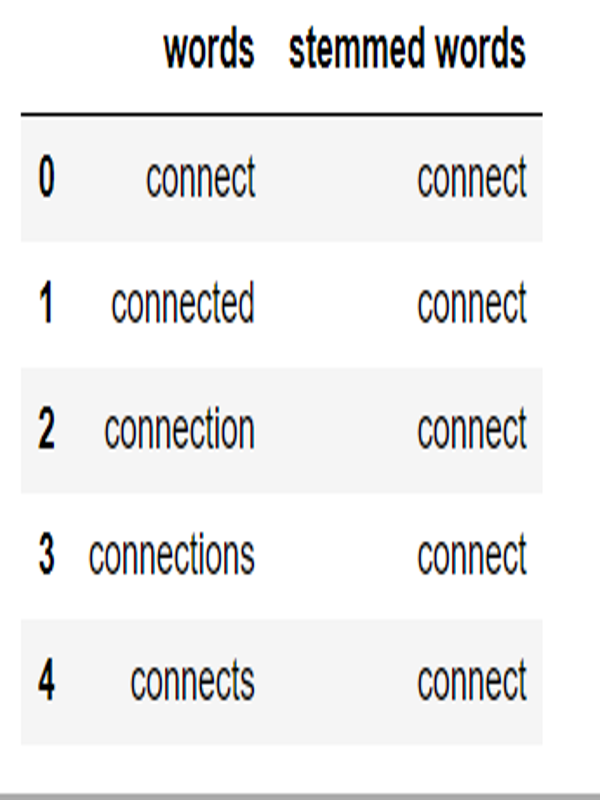

In [ ]:
image = load_image("/content/drive/MyDrive/output2/page3_img2.png")
image.resize((600, 800))